## Model-Multi-Tissue

The reactions of tissue models are constrained in two ways: exchange reactions (uptake and output) and internally (Eflux, vmax etc). 

For the second cohort we do a ratio model. We take the of metabolomics of two conditions and the ratio of the Eflux constraint.

In [1]:
import csv
from math import log
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from collections import defaultdict
from math import log
from pyvalem.formula import Formula
from scipy.spatial import distance
import plotly
import mat73
from scipy.spatial import distance

## LOCAL FUNCTIONS

In [102]:
def normaliseToModel(df,model):
    base = dict(zip(df[df['Model'] == model]['Metabolite'],df[df['Model'] == model]['Pseudoflux']))
    for index,row in df.iterrows():
        df.at[index,'normalised('+model+')'] = log(row['Pseudoflux'] / base[row['Metabolite']])
    return df

In [103]:
def setPlotFont(fig):
    fig = fig
    fig.update_layout(font=dict(family="Arial",color="black",size = 12))
    return fig

In [104]:
def calculateTotalCarbon(DF,models):
    d = {}
    for model in models:
        df = DF[DF['Model'] == model]
        d[model] = df['Cmoles'].sum()
    return d

In [105]:
def fixSubsystems(df):
    df.at['community_biomass','SUBSYSTEM'] = 'Exchange/demand reaction'
    df['SUBSYSTEM'] = df['SUBSYSTEM'].fillna('Gut biomass reactions')
    return df

In [106]:
def assignFluxGroup(flux,metabolite,cutoff):
    if abs(flux) <= cutoff:
        return 'low'
    else:
        return metabolite

In [107]:
def plotSingleReaction(reaction,experiments,dfs):
    d = []
    for exp in experiments:
        df = dfs[exp]
        d.append({'Model' : exp,'Reaction' : reaction, 'Equation' : df.at[reaction,'EQUATION'],
                  'Flux' : df.at[reaction,'FLUX']})
    out = pd.DataFrame(d)
    return out

In [108]:
def reformatToMatrix(df,x,y,query_column):
    out = pd.DataFrame()
    for index,row in df.iterrows():
        out.at[row[y],row[x]] = row[query_column]
    return out   

In [109]:
def getZeroCmoles(df,carbon_matrix):
    mets = set(df[df['Cmoles'] == 0].Metabolite_full.tolist())
    final = []
    for met in mets:
        if carbon_matrix[met] == 0:
            final.append(met)
    return final

In [110]:
def toPlotInput(dfs,experiments,carbon_matrix,metabolite_mapping,query_subsystem):
    d = []
    diet_to_tissues = ['Diet-gut exchange','Diet-blood exchange','gut_to_blood_exchange']
    for exp in experiments:
        df = dfs[exp]
        df = df[df['SUBSYSTEM'] == query_subsystem]
        if query_subsystem not in diet_to_tissues:
            df = df[df['FLUX'] < 0]
        exp_parts = exp.split('_')
        diet = exp_parts[0]
        condition = str('_'.join(exp_parts[1:]))
        for index,row in df.iterrows():
            if query_subsystem in diet_to_tissues:
                metabolite_full = row['EQUATION'].split('=>')[1].strip()
            else:
                metabolite_full = row['EQUATION'].replace('<=>','').strip()
                metabolite_full = metabolite_full.replace('=>','').strip()
            met_parts = metabolite_full.split('[')
            metabolite = str('['.join(met_parts[0:-1]))
            if metabolite_full in metabolite_mapping:
                met_map = metabolite_mapping[metabolite_full]
            elif metabolite in metabolite_mapping:
                met_map = metabolite_mapping[metabolite]
            else:
                met_map = 'Other'
            d.append({'Model' : exp,
                      'Condition' : condition,
                      'Diet' : diet,
                      'Reaction' : index,
                      'Metabolite' : metabolite,
                      'Metabolite_full' : metabolite_full,
                      'Flux' : row['FLUX'],
                      'Cmoles' : row['FLUX'] * carbon_matrix[metabolite_full],
                      'Pseudoflux' : row['FLUX'] - 0.01,
                      'Metabolite_group' : met_map})
    toPlot = pd.DataFrame(d)
    return toPlot

In [111]:
def toPlotOutput(dfs,experiments,carbon_matrix,metabolite_mapping,query_subsystem):
    d = []
    for exp in experiments:
        df = dfs[exp]
        df = df[df['SUBSYSTEM'] == query_subsystem]
        df = df[df['FLUX'] > 0]
        if query_subsystem == 'Exchange/demand reaction':
            df = df[df.index.str.contains('EX_')]
        exp_parts = exp.split('_')
        diet = exp_parts[0]
        condition = str('_'.join(exp_parts[1:]))
        for index,row in df.iterrows():
            metabolite_full = row['EQUATION'].replace('<=>','').strip()
            metabolite_full = metabolite_full.replace('=>','').strip()
            met_parts = metabolite_full.split('[')
            metabolite = str('['.join(met_parts[0:-1]))
            if metabolite_full in metabolite_mapping:
                met_map = metabolite_mapping[metabolite_full]
            elif metabolite in metabolite_mapping:
                met_map = metabolite_mapping[metabolite]
            else:
                met_map = 'Other'
            d.append({'Model' : exp,
                      'Condition' : condition,
                      'Diet' : diet,
                      'Reaction' : index,
                      'Metabolite' : metabolite,
                      'Metabolite_full' : metabolite_full,
                      'Flux' : row['FLUX'],
                      'Cmoles' : row['FLUX'] * carbon_matrix[metabolite_full],
                      'Pseudoflux' : row['FLUX'] - 0.01,
                      'Metabolite_group' : met_map})
    toPlot = pd.DataFrame(d)
    return toPlot

In [112]:
def toPlotExchange(dfs,experiments,carbon_matrix,metabolite_mapping,query_subsystem):
    d = []
    for exp in experiments:
        df = dfs[exp]
        df = df[df['SUBSYSTEM'] == query_subsystem]
        df = df[df['FLUX'] != 0]
        diet = exp_parts[0]
        condition = str('_'.join(exp_parts[1:]))
        for index,row in df.iterrows():
            metabolite_full = row['EQUATION'].split('<=>')[1].strip()
            if "'" in metabolite_full:
                metabolite_full = metabolite_full.replace("'","")
            met_parts = metabolite_full.split('[')
            metabolite = str('['.join(met_parts[0:-1]))
            if metabolite_full in metabolite_mapping:
                met_map = metabolite_mapping[metabolite_full]
            elif metabolite in metabolite_mapping:
                met_map = metabolite_mapping[metabolite]
            else:
                met_map = 'Other'
            d.append({'Model' : exp,
                      'Condition' : condition,
                      'Diet' : diet,
                      'Reaction' : index,
                      'Metabolite' : metabolite,
                      'Metabolite_full' : metabolite_full,
                      'Flux' : row['FLUX'],
                      'Cmoles' : row['FLUX'] * carbon_matrix[metabolite_full],
                      'Pseudoflux' : row['FLUX'] - 0.01,
                      'Metabolite_group' : met_map})
    toPlot = pd.DataFrame(d)
    return toPlot

In [113]:
def fluxGroup(df,col,cutoff):  
    for index,row in df.iterrows():
        if abs(row[col]) <= cutoff:
            df.at[index,'fluxGroup'] = 'low'
        else:
            df.at[index,'fluxGroup'] = row['Metabolite']
    return df

### Generate composition file

In [114]:
dfs = []
for sheet in ['nonDEN_fed','nonDEN_fasted','DEN_fed','DEN_fasted']:
    print(sheet)
    dfs.append(pd.read_excel('data/metFormulas.xlsx',sheet_name=sheet,index_col=0))
final_df = pd.concat(dfs)
carbon_matrix = dict(zip(final_df.index,final_df['C']))

nonDEN_fed
nonDEN_fasted
DEN_fed
DEN_fasted


In [115]:
#for met in carbon_matrix:
#    if 'LDL[' in met and 'VLDL' not in met:
#        carbon_matrix[met] = 94027
carbon_matrix['CDP-diacylglycerol-LD-PI pool[b]'] = 34
#carbon_matrix['1,2-diacylglycerol-LD-PC pool[w_c]'] = 0
#carbon_matrix['CDP-diacylglycerol-LD-PI pool[b]'] = 50
#carbon_matrix['cholesterol-ester pool[b]'] = 28

## IMPORT DATA

In [116]:
EXP = 'SIM2'
experiments = ['CD_nonDEN_Fed','CD_nonDEN_Fasted','CD_DEN_Fed','CD_DEN_Fasted',
               'WD_nonDEN_Fed','WD_nonDEN_Fasted','WD_DEN_Fed','WD_DEN_Fasted']
dfs = pd.read_excel('output/FBA/'+EXP+'.xlsx',sheet_name=experiments,index_col=0)
for exp in experiments:
    print(exp)
    dfs[exp] = fixSubsystems(dfs[exp])
    dfs[exp] = dfs[exp].rename(index={'community_biomass' : 'EX_community_biomass'})

CD_nonDEN_Fed
CD_nonDEN_Fasted
CD_DEN_Fed
CD_DEN_Fasted
WD_nonDEN_Fed
WD_nonDEN_Fasted
WD_DEN_Fed
WD_DEN_Fasted


In [117]:
df = pd.read_csv('data/diet_metabolite_group_mapping.csv')
metabolite_group_map = dict(zip(df['Metabolite'],df['Group']))
l = list(metabolite_group_map.keys())
for metabolite in l:
    met_parts = metabolite.split('[')
    met = str('['.join(met_parts[0:-1]))
    metabolite_group_map[met] = metabolite_group_map[metabolite]
metabolite_group_map['biomass'] = 'biomass'
metabolite_group_map['CO2'] = 'CO2'
metabolite_group_map['carbon dioxide'] = 'CO2'

#### Concatenate tissue fluxes to dataframe

In [148]:
count = 0
for exp in experiments:
    if count == 0:
        tissue_df = dfs[exp].rename(columns={'FLUX':exp})
    else:
        df = pd.DataFrame(dfs[exp]['FLUX']).rename(columns={'FLUX':exp})
        tissue_df = tissue_df.join(df,how='inner')
    count += 1

In [149]:
tissue_df.to_csv('output/FBA/'+EXP+'_combined.csv')

In [41]:
SIM1 = tissue_df[tissue_df.index.str.startswith('t_')]
SIM1 = SIM1.drop(columns=['EQUATION','SUBSYSTEM','LB','UB','CD_nonDEN_Fasted','CD_nonDEN_Fed',
                          'WD_nonDEN_Fasted','WD_nonDEN_Fed'])
SIM1.index = SIM1.index.str.replace('t_', '')

In [42]:
SIM4 = pd.read_excel('output/FBA/SIM4.xlsx',sheet_name='SIM4',index_col=0)
SIM4 = SIM4.drop(columns=['EQUATION','SUBSYSTEM','GENEASSOCIATION'])

In [49]:
df = SIM4.join(SIM1,how='inner')
experiments = df.columns
dist_mat = pd.DataFrame()
for exp1 in experiments:
    for exp2 in experiments:
        dist_mat.at[exp1,exp2] = distance.euclidean(df[exp1],df[exp2])
dist_mat = dist_mat.div(dist_mat.max().max())

In [50]:
dist_mat

,CD_DEN_Tumour_fed,CD_DEN_Tumour_fasted,WD_DEN_Tumour_fed,WD_DEN_Tumour_fasted,CD_DEN_Fed,CD_DEN_Fasted,WD_DEN_Fed,WD_DEN_Fasted
CD_DEN_Tumour_fed,0.000000,0.515221,0.642090,0.649170,0.713573,0.668377,1.000000,0.934913
CD_DEN_Tumour_fasted,0.515221,0.000000,0.448414,0.454056,0.608596,0.584767,0.890530,0.800101
WD_DEN_Tumour_fed,0.642090,0.448414,0.000000,0.277341,0.661909,0.663645,0.887168,0.778760
WD_DEN_Tumour_fasted,0.649170,0.454056,0.277341,0.000000,0.650549,0.663889,0.871938,0.772449
CD_DEN_Fed,0.713573,0.608596,0.661909,0.650549,0.000000,0.337644,0.705316,0.604392
CD_DEN_Fasted,0.668377,0.584767,0.663645,0.663889,0.337644,0.000000,0.702435,0.641745
WD_DEN_Fed,1.000000,0.890530,0.887168,0.871938,0.705316,0.702435,0.000000,0.444556
WD_DEN_Fasted,0.934913,0.800101,0.778760,0.772449,0.604392,0.641745,0.444556,0.000000


# Plot single reaction flux

In [72]:
d = []
for index,row in df.iterrows():
    if index=='MMRN_Biomass':
        for col in df.columns:
            d.append({'Model' : col,
                      'Flux' : row[col]})
            if col == 'WD_DEN_Tumour_fasted':
                d.append({'Model' : 'space',
                          'Flux' : 0})
toPlot = pd.DataFrame(d)
fig = px.bar(toPlot,x='Model',y='Flux',color='Model',
             color_discrete_sequence=['black']) #'lightblue','darkblue','red','darkred'
fig.update_layout(template='none',autosize=False,height=400,width=400,showlegend=False)
fig = setPlotFont(fig)
fig.write_image('/Users/clasenf/OneDrive - The Francis Crick Institute/PhD Pathway/Thesis/Figures/Chapter6/biomass_flux2.pdf')
fig.show()

In [62]:
toPlot

,Model,Flux
0,CD_DEN_Tumour_fed,1.553404
1,CD_DEN_Tumour_fasted,2.405547
2,WD_DEN_Tumour_fed,2.547027
3,WD_DEN_Tumour_fasted,2.537565
4,CD_DEN_Fed,2.975006
5,CD_DEN_Fasted,2.975006
6,WD_DEN_Fed,3.302896
7,WD_DEN_Fasted,3.506579


In [95]:
liver = plotSingleReaction('l_EXC_BOTH_C00042[s]',experiments,dfs)
#wat = plotSingleReaction('w_MMRN_Biomass',experiments,dfs)
#tumour = plotSingleReaction('t_EXC_BOTH_C00249[s]',experiments,dfs)

out_comb = pd.concat([liver])
out_comb['Flux'] = out_comb['Flux'].abs()
out_comb = out_comb[out_comb['Model'].isin(['CD_DEN_Fed','CD_DEN_Fasted','WD_DEN_Fed','WD_DEN_Fasted'])]
#out_comb = out_comb[out_comb['Flux'] != 0]
fig = px.bar(out_comb,x='Model',y='Flux',color='Model',
             color_discrete_sequence=['lightblue','darkblue','red','darkred']) #'lightblue','darkblue','red','darkred'
fig.update_layout(template='none',autosize=False,height=400,width=300,showlegend=False)
fig = setPlotFont(fig)
fig.write_image('output/figures/SIM2/l2t_succinate_l2.pdf')
fig.show()

In [49]:
liver = plotSingleReaction('EXC_BOTH_biomass[b]',experiments,dfs)
#wat = plotSingleReaction('w_MMRN_Biomass',experiments,dfs)
#tumour = plotSingleReaction('t_EXC_BOTH_C00249[s]',experiments,dfs)

out_comb = pd.concat([liver])
out_comb['Flux'] = out_comb['Flux'].abs()
#out_comb = out_comb[out_comb['Model'].isin(['CD_DEN_Fed','CD_DEN_Fasted','WD_DEN_Fed','WD_DEN_Fasted'])]
#out_comb = out_comb[out_comb['Flux'] != 0]
fig = px.bar(out_comb,x='Model',y='Flux',color='Model',
             color_discrete_sequence=['lightblue','darkblue','red','darkred']) #'lightblue','darkblue','red','darkred'
fig.update_layout(template='none',autosize=False,height=400,width=300,showlegend=False)
fig = setPlotFont(fig)
#fig.write_image('output/figures/SIM2/l2t_succinate.pdf')
fig.show()

# Calculate euclidean distances

In [59]:
df = tissue_df[tissue_df['SUBSYSTEM'] == 'l_Beta-oxidation (mitochondrial)']
df = df[df['EQUATION'].str.contains('acetyl-CoA')]
stoic = []
for index,row in df.iterrows():
    i = row['EQUATION'].split('=>')[1]
    for j in i.split(' + '):
        if 'acetyl-CoA' in j:
            j = j.replace('acetyl-CoA[l_m]','').strip()
            try:
                stoic.append(int(j))
            except ValueError:
                stoic.append(1)
df = df.mul(stoic, axis=0)
df.sum()

EQUATION            3-oxolaur-6-cis-enoyl-CoA[l_m] + CoA[l_m] => 4...
SUBSYSTEM           l_Beta-oxidation (mitochondrial)l_Beta-oxidati...
LB                                                                0.0
UB                                                       27727.208358
CD_nonDEN_Fed                                                7.428594
CD_nonDEN_Fasted                                             7.529056
CD_DEN_Fed                                                   3.708711
CD_DEN_Fasted                                                3.272177
WD_nonDEN_Fed                                                12.63784
WD_nonDEN_Fasted                                            12.750351
WD_DEN_Fed                                                   9.325972
WD_DEN_Fasted                                                7.110232
dtype: object

In [20]:
dist_df = tissue_df.drop(columns=['EQUATION','SUBSYSTEM','LB','UB'])
dist_df = dist_df[dist_df.index.str.startswith('l_')]
#dist_df = dist_df[~dist_df.index.str.startswith('l_EXC')]
dist_df = dist_df.loc[(dist_df!=0).any(axis=1)]
dist_mat = pd.DataFrame()
for exp1 in experiments:
    for exp2 in experiments:
        dist_mat.at[exp1,exp2] = distance.euclidean(dist_df[exp1],dist_df[exp2])
#dist_mat = dist_mat.div(dist_mat.max().max())

In [21]:
dist_df = tissue_df.drop(columns=['EQUATION','SUBSYSTEM','LB','UB'])
dist_df = dist_df[dist_df.index.str.startswith('l_')]
dist_df.index = dist_df.index.str[2:]
l_dist_df = dist_df.add_prefix('l_')

dist_df = tissue_df.drop(columns=['EQUATION','SUBSYSTEM','LB','UB','CD_nonDEN_Fed','CD_nonDEN_Fasted',
                                  'WD_nonDEN_Fed','WD_nonDEN_Fasted'])
dist_df = dist_df[dist_df.index.str.startswith('t_')]
dist_df.index = dist_df.index.str[2:]
t_dist_df = dist_df.add_prefix('t_')

dist_df = l_dist_df.join(t_dist_df,how='inner')
dist_df = dist_df.loc[(dist_df!=0).any(axis=1)]
dist_df = dist_df[['l_CD_nonDEN_Fed', 'l_CD_nonDEN_Fasted', 
                   'l_CD_DEN_Fed','t_CD_DEN_Fed',
                   'l_CD_DEN_Fasted', 't_CD_DEN_Fasted',
                   'l_WD_nonDEN_Fed', 'l_WD_nonDEN_Fasted',
                   'l_WD_DEN_Fed','t_WD_DEN_Fed',
                   'l_WD_DEN_Fasted','t_WD_DEN_Fasted']]
experiments = dist_df.columns
dist_mat = pd.DataFrame()
for exp1 in experiments:
    for exp2 in experiments:
        dist_mat.at[exp1,exp2] = distance.euclidean(dist_df[exp1],dist_df[exp2])
dist_mat = dist_mat.div(dist_mat.max().max())

In [22]:
for index,row in dist_df.iterrows():
    dist_df.at[index,'EQUATION'] = tissue_df.at['l_'+index,'EQUATION']
    dist_df.at[index,'SUBSYSTEM'] = tissue_df.at['l_'+index,'SUBSYSTEM']
dist_df.to_csv('output/FBA/'+EXP+'_combined2.csv')

In [51]:
z = []
for exp in experiments:
    z.append(list(dist_mat[exp]))

In [71]:
all_val = []
for i in z:
    for j in i:
        all_val.append(j)
m = min(i for i in all_val if i > 0)
fig = go.Figure(data=go.Heatmap(z = z,x = experiments,y = experiments,zmin=0,zmax=1,
                                colorscale=[(0, "white"),(m-0.01,"white"),(1, "darkblue")],
                                reversescale=False))
fig.update_layout(template = 'none',title='',xaxis_nticks=0,yaxis_nticks=0,
                  autosize=False,width=400,height=400,
                  margin=dict(l=100,r=50,b=100,t=50,pad=4),
                  font=dict(size=8,family='Arial',color="black"))
fig.update_xaxes(showticklabels=True,tickangle=90)
fig.write_image('/Users/clasenf/OneDrive - The Francis Crick Institute/PhD Pathway/Thesis/Figures/Chapter6/distances.pdf')
fig.show()

In [87]:
comps = ['CD_nonDEN_Fed_vs_CD_nonDEN_Fasted',
         'CD_nonDEN_Fed_vs_CD_DEN_Fed',
         'CD_nonDEN_Fasted_vs_CD_DEN_Fasted',
         'CD_DEN_Fed_vs_CD_DEN_Fasted',
         
         'WD_nonDEN_Fed_vs_WD_nonDEN_Fasted',
         'WD_nonDEN_Fed_vs_WD_DEN_Fed',
         'WD_nonDEN_Fasted_vs_WD_DEN_Fasted',
         'WD_DEN_Fed_vs_WD_DEN_Fasted',]
d = []
for comp in comps:
    parts = comp.split('_vs_')
    d.append({'Comp' : comp,
              'Distance' : dist_mat.at[parts[0],parts[1]]})
toPlot = pd.DataFrame(d)
fig = px.bar(toPlot,x='Comp',y='Distance',template='none',color_discrete_sequence=['black'])
fig.update_layout(autosize=False,width=350,height=600,
                  margin=dict(l=50,r=50,b=400,t=50,pad=4))
fig.update_xaxes(showticklabels=True,tickangle=270)
fig = setPlotFont(fig)
fig.write_image('output/figures/SIM2/distances_barplot.pdf')
fig.show()

# Calculate system uptake and exchange

The model input is dietary content uptake and sink metabolites into blood and gut respectively

The output is out of the gut and the blood respectively

## SYSTEM INPUT

### DIET

In [118]:
toPlot_input_diet = toPlotInput(dfs,experiments,carbon_matrix,metabolite_group_map,'Diet exchange')

In [119]:
cols = plotly.colors.qualitative.Pastel[0:7]
toPlot_input_diet['Cmoles'] = -1*toPlot_input_diet['Cmoles']
fig = px.bar(toPlot_input_diet,x='Model',y='Cmoles',color='Metabolite_group',
             category_orders={"Metabolite_group": ['Carbohydrates','Lipids','Amino acids']},
             color_discrete_sequence=[cols[1],cols[2],cols[3]])
fig.update_layout(template='none',autosize=False,width=400,height=300)
fig.update_yaxes(title='', visible=True, showticklabels=True)
fig.update_xaxes(title='', visible=False, showticklabels=True)
#fig.update_yaxes(range=[0, toPlot_input_diet[toPlot_input_diet['Model'] == 'WD_DEN_Fed']['Flux'].sum()])
fig = setPlotFont(fig)
#fig.write_image('output/figures/'+EXP+'/input_diet.svg')
fig.show()

### SINKS (GUT)

In [120]:
toPlot_input_gutsinks = toPlotInput(dfs,experiments,carbon_matrix,metabolite_group_map,'Exchange/demand reaction')
toPlot_input_gutsinks['Cmoles'] = -1*toPlot_input_gutsinks['Cmoles']
#toPlot_input_gutsinks = fluxGroup(toPlot_input_gutsinks,'Cmoles',4)

In [121]:
fig = px.bar(toPlot_input_gutsinks,x='Model',y='Cmoles',color='Metabolite')
fig.update_layout(template='none',autosize=False,width=600,height=300)
fig.show()

### SINKS (BLOOD)

In [122]:
toPlot_input_bloodsinks = toPlotInput(dfs,experiments,carbon_matrix,metabolite_group_map,'Blood exchange')
toPlot_input_watsinks = toPlotInput(dfs,experiments,carbon_matrix,metabolite_group_map,'w_Sink reactions')
toPlot_input_tissuesinks = pd.concat([toPlot_input_bloodsinks,toPlot_input_watsinks])
toPlot_input_tissuesinks['Cmoles'] = -1*toPlot_input_tissuesinks['Cmoles']

In [123]:
fig = px.bar(toPlot_input_tissuesinks,x='Model',y='Cmoles',color='Metabolite')
fig.update_layout(template='none',autosize=False,width=400,height=300)
fig.show()

### CONCATENATED

In [124]:
INPUT = pd.concat([toPlot_input_diet,toPlot_input_gutsinks,toPlot_input_tissuesinks])
cols = plotly.colors.qualitative.Pastel[0:7]
fig = px.bar(INPUT,x='Model',y='Cmoles',color='Metabolite_group',
             color_discrete_sequence=[cols[1],cols[2],cols[3],cols[4]],
             category_orders={"Metabolite_group": ['Carbohydrates','Lipids','Amino acids','Other']})
fig.update_layout(template='none',autosize=False,width=400,height=300)
fig.update_yaxes(title='', visible=True, showticklabels=True)
fig.update_xaxes(title='', visible=False, showticklabels=True)
fig = setPlotFont(fig)
#fig.write_image('output/figures/'+EXP+'/input_all.svg')
fig.show()

## Diet to gut and blood

### To determine how flux distribute from diet to gut and blood 

### Diet to gut

In [125]:
toPlot_diet_to_gut = toPlotInput(dfs,experiments,carbon_matrix,metabolite_group_map,'Diet-gut exchange')

In [126]:
cols = plotly.colors.qualitative.Pastel[0:7]
fig = px.bar(toPlot_diet_to_gut,x='Model',y='Cmoles',color='Metabolite_group',
             category_orders={"Metabolite_group": ['Carbohydrates','Lipids','Amino acids']},
             color_discrete_sequence=[cols[1],cols[2],cols[3]])
fig.update_layout(template='none',autosize=False,width=400,height=300)
#fig.update_yaxes(range=[0, toPlot_input_diet.groupby(['Model']).sum()['Cmoles'].max()])
fig.update_yaxes(title='', visible=True, showticklabels=True)
fig.update_xaxes(title='', visible=False, showticklabels=True)
fig = setPlotFont(fig)
#fig.write_image('output/figures/'+EXP+'/input_diet_to_gut.svg')
fig.show()

### Diet to blood

In [127]:
toPlot_diet_to_blood = toPlotInput(dfs,experiments,carbon_matrix,metabolite_group_map,'Diet-blood exchange')

In [128]:
cols = plotly.colors.qualitative.Pastel[0:7]
fig = px.bar(toPlot_diet_to_blood,x='Model',y='Cmoles',color='Metabolite_group',
             color_discrete_sequence=[cols[1],cols[2],cols[3]],
             category_orders={"Metabolite_group": ['Carbohydrates','Lipids','Amino acids']})
fig.update_layout(template='none',autosize=False,width=400,height=300)
#fig.update_yaxes(range=[0, toPlot_input_diet.groupby(['Model']).sum()['Cmoles'].max()])
fig.update_yaxes(title='', visible=True, showticklabels=True)
fig.update_xaxes(title='', visible=False, showticklabels=True)
fig = setPlotFont(fig)
#fig.write_image('output/figures/'+EXP+'/input_diet_to_blood.svg')
fig.show()

## SYSTEM OUTPUT

### For the gut we first calculate the gut-to-blood exchange and then the gut-output out of the system. Then we finally use the total input and output to calculate the biomass Cmoles

### GUT-TO-BLOOD

In [129]:
toPlot_gut_to_blood = toPlotInput(dfs,experiments,carbon_matrix,metabolite_group_map,'gut_to_blood_exchange')
toPlot_gut_to_blood = toPlot_gut_to_blood[toPlot_gut_to_blood['Cmoles'] != 0]
toPlot_gut_to_blood = fluxGroup(toPlot_gut_to_blood,'Cmoles',2)

In [130]:
fig = px.bar(toPlot_gut_to_blood,x='Model',y='Cmoles',color='fluxGroup',
            color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_layout(template='none',autosize=False,width=400,height=450)
fig.update_yaxes(title='', visible=True, showticklabels=True)
#fig.update_xaxes(title='', visible=False, showticklabels=True)
fig.update_xaxes(categoryorder='array', categoryarray=experiments)
fig = setPlotFont(fig)
#fig.write_image('output/figures/'+EXP+'/gut_to_blood.svg')
fig.show()

### GUT EXCHANGE


In [154]:
toPlot_output_gut = toPlotOutput(dfs,experiments,carbon_matrix,metabolite_group_map,'Exchange/demand reaction')
#toPlot_output_gut = toPlot_output_gut[toPlot_output_gut['Cmoles'] != 0]
toPlot_output_gut = fluxGroup(toPlot_output_gut,'Cmoles',2)

In [156]:
fig = px.bar(toPlot_output_gut,x='Model',y='Cmoles',color='Metabolite',
            color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_layout(template='none',autosize=False,width=400,height=400)
fig.update_yaxes(title='', visible=True, showticklabels=True)
#fig.update_xaxes(title='', visible=False, showticklabels=True)
fig.update_xaxes(categoryorder='array', categoryarray=experiments)
fig = setPlotFont(fig)
#fig.write_image('output/figures/'+EXP+'/output_gut_others.svg')
fig.show()

In [133]:
#toPlot_diet_to_gut_copy = toPlot_diet_to_gut.copy()
#toPlot_diet_to_gut_copy['Cmoles'] = -1*toPlot_diet_to_gut_copy['Cmoles']
Cmoles_IN = pd.concat([toPlot_input_gutsinks,toPlot_diet_to_gut]).groupby(['Model']).sum()['Cmoles']
Cmoles_OUT = pd.concat([toPlot_output_gut,toPlot_gut_to_blood]).groupby(['Model']).sum()['Cmoles']
biomass = dict(Cmoles_IN - Cmoles_OUT)
final_gut_output = toPlot_output_gut.copy()
for model in biomass:
    i = final_gut_output[(final_gut_output.Model == model) & (final_gut_output.Metabolite == 'biomass')].index[0]
    final_gut_output.at[i,'Cmoles'] = biomass[model]
final_gut_output = final_gut_output.replace({'Metabolite_group':{'Lipids' : 'Other','Amino acids' : 'Other'}})

In [134]:
#toPlot_output_blood = toPlot_output_blood[toPlot_output_blood['Metabolite Group'] == 'Biomass']
fig = px.bar(final_gut_output,x='Model',y='Cmoles',color='Metabolite_group',
             color_discrete_sequence=['black','darkgrey','grey'],
             category_orders={"Metabolite_group": ['biomass','CO2','Other']})
fig.update_layout(template='none',autosize=False,width=400,height=300)
fig.update_yaxes(title='', visible=True, showticklabels=True)
#fig.update_xaxes(title='', visible=False, showticklabels=True)
fig = setPlotFont(fig)
#fig.write_image('output/figures/'+EXP+'/output_gut.svg')
fig.show()

### For the tissues we calculate the blood output and then use this with the diet input, sinks and gut-to-blood to calculate biomass Cmoles

In [138]:
toPlot_output_blood = toPlotOutput(dfs,experiments,carbon_matrix,metabolite_group_map,'Blood exchange')

In [139]:
toPlot_output_blood = toPlot_output_blood[toPlot_output_blood['Flux'] > 0.01]
toPlot_output_blood = toPlot_output_blood[toPlot_output_blood['Metabolite_group'] == 'Other']
toPlot_output_blood = fluxGroup(toPlot_output_blood,'Cmoles',3)
fig = px.bar(toPlot_output_blood,x='Model',y='Cmoles',color='fluxGroup')
fig.update_layout(template='none',autosize=False,width=450,height=400)
fig = setPlotFont(fig)
fig.update_xaxes(categoryorder='array', categoryarray=experiments)
#fig.write_image('output/figures/'+EXP+'/output_blood_others.svg')
fig.show()

In [140]:
#toPlot_input_bloodsinks_copy = toPlot_input_bloodsinks.copy()
#toPlot_input_bloodsinks_copy['Cmoles'] = -1*toPlot_input_bloodsinks_copy['Cmoles']
Cmoles_IN = pd.concat([toPlot_input_tissuesinks,toPlot_gut_to_blood,toPlot_diet_to_blood]).groupby(['Model']).sum()['Cmoles']
Cmoles_OUT = toPlot_output_blood.groupby(['Model']).sum()['Cmoles']
biomass = dict(Cmoles_IN - Cmoles_OUT)
final_blood_output = toPlot_output_blood.copy()
for model in biomass:
    try:
        i = final_blood_output[(final_blood_output.Model == model) & (final_blood_output.Metabolite == 'biomass')].index[0]
        final_blood_output.at[i,'Cmoles'] = biomass[model]
    except IndexError:
        pass
final_blood_output = final_blood_output.replace({'Metabolite_group':{'Lipids' : 'Other','Amino acids' : 'Other'}})


In [141]:
#toPlot_output_blood = toPlot_output_blood[toPlot_output_blood['Metabolite Group'] == 'Biomass']
fig = px.bar(final_blood_output,x='Model',y='Cmoles',color='Metabolite_group',
             color_discrete_sequence=['black','darkgrey','grey'],
             category_orders={"Metabolite_group": ['biomass','CO2','Other']})
fig.update_layout(template='none',autosize=False,width=400,height=300)
fig.update_yaxes(title='', visible=True, showticklabels=True)
fig.update_xaxes(title='', visible=False, showticklabels=True)
fig.update_xaxes(categoryorder='array', categoryarray=experiments)
fig = setPlotFont(fig)
#fig.write_image('output/figures/'+EXP+'/output_blood.svg')
fig.show()

In [142]:
final_output = pd.concat([final_gut_output,final_blood_output])

In [143]:
#toPlot_output_blood = toPlot_output_blood[toPlot_output_blood['Metabolite Group'] == 'Biomass']
fig = px.bar(final_output,x='Model',y='Cmoles',color='Metabolite_group',
             color_discrete_sequence=['black','darkgrey','grey'],
             category_orders={"Metabolite_group": ['biomass','CO2','Other']})
fig.update_layout(template='none',autosize=False,width=400,height=300)
fig.update_yaxes(title='', visible=True, showticklabels=True)
fig.update_xaxes(title='', visible=False, showticklabels=True)
fig = setPlotFont(fig)
#fig.write_image('output/figures/'+EXP+'/output.svg')
fig.show()

## Internal exchanges

In [97]:
def toPlotExchange(dfs,experiments,carbon_matrix,query_subsystem):
    d = []
    for exp in experiments:
        exp_parts = exp.split('_')
        df = dfs[exp]
        df = df[df['SUBSYSTEM'] == query_subsystem]
        df = df[df['FLUX'].abs() >= 0.01]
        if query_subsystem == 'Exchange/demand reaction':
            df = df[df['FLUX'] > 0]
        diet = exp_parts[0]
        condition = str('_'.join(exp_parts[1:]))
        for index,row in df.iterrows():
            if '<=>' in row['EQUATION']:
                metabolite_full = row['EQUATION'].split('<=>')[0].strip()
            else:
                metabolite_full = row['EQUATION'].split('=>')[0].strip()
            if "'" in metabolite_full:
                metabolite_full = metabolite_full.replace("'","")
            met_parts = metabolite_full.split('[')
            metabolite = str('['.join(met_parts[0:-1]))
            d.append({'Model' : exp,
                      'Condition' : condition,
                      'Diet' : diet,
                      'Reaction' : index,
                      'Metabolite' : metabolite,
                      'Metabolite_full' : metabolite_full,
                      'Flux' : row['FLUX'],
                      'Cmoles' : row['FLUX'] * carbon_matrix[metabolite_full],
                      'Pseudoflux' : row['FLUX'] - 0.01})
    toPlot = pd.DataFrame(d)
    toPlot_mat = pd.DataFrame()
    for index,row in toPlot.iterrows():
        toPlot_mat.at[row['Metabolite'],row['Model']] = row['Flux']
    toPlot_mat = toPlot_mat.fillna(0)
    toPlot_mat = toPlot_mat.div(toPlot_mat.abs().max(axis=1),axis=0)
    return [toPlot,toPlot_mat]

In [98]:
set(toPlotExchange(dfs,experiments,carbon_matrix,'l2t_Exchange reactions')[0].Reaction)

{'l2t_EXC_BOTH_C00001[s]',
 'l2t_EXC_BOTH_C00002[s]',
 'l2t_EXC_BOTH_C00009[s]',
 'l2t_EXC_BOTH_C00014[s]',
 'l2t_EXC_BOTH_C00022[s]',
 'l2t_EXC_BOTH_C00025[s]',
 'l2t_EXC_BOTH_C00026[s]',
 'l2t_EXC_BOTH_C00031[s]',
 'l2t_EXC_BOTH_C00033[s]',
 'l2t_EXC_BOTH_C00037[s]',
 'l2t_EXC_BOTH_C00041[s]',
 'l2t_EXC_BOTH_C00042[s]',
 'l2t_EXC_BOTH_C00051[s]',
 'l2t_EXC_BOTH_C00058[s]',
 'l2t_EXC_BOTH_C00062[s]',
 'l2t_EXC_BOTH_C00064[s]',
 'l2t_EXC_BOTH_C00065[s]',
 'l2t_EXC_BOTH_C00077[s]',
 'l2t_EXC_BOTH_C00080[s]',
 'l2t_EXC_BOTH_C00095[s]',
 'l2t_EXC_BOTH_C00097[s]',
 'l2t_EXC_BOTH_C00101[s]',
 'l2t_EXC_BOTH_C00116[s]',
 'l2t_EXC_BOTH_C00148[s]',
 'l2t_EXC_BOTH_C00152[s]',
 'l2t_EXC_BOTH_C00158[s]',
 'l2t_EXC_BOTH_C00163[s]',
 'l2t_EXC_BOTH_C00164[s]',
 'l2t_EXC_BOTH_C00207[s]',
 'l2t_EXC_BOTH_C00212[s]',
 'l2t_EXC_BOTH_C00214[s]',
 'l2t_EXC_BOTH_C00219[s]',
 'l2t_EXC_BOTH_C00288[s]',
 'l2t_EXC_BOTH_C00299[s]',
 'l2t_EXC_BOTH_C00300[s]',
 'l2t_EXC_BOTH_C00440[s]',
 'l2t_EXC_BOTH_C00475[s]',
 

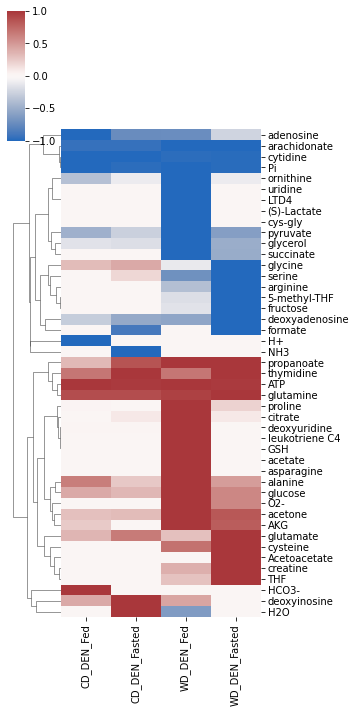

In [99]:
toPlot_output_liver = toPlotExchange(dfs,experiments,carbon_matrix,'l2t_Exchange reactions')[1]
p = sns.clustermap(toPlot_output_liver,col_cluster=False,cmap='vlag',center=0,yticklabels=True,figsize=(5,10))
#p.savefig('output/figures/'+EXP+'/l2t_heatmap.svg')

In [272]:
toPlot_liver_to_blood = toPlotExchange(dfs,experiments,carbon_matrix,'l_Exchange reactions')[0]
toPlot_liver_to_blood = toPlot_liver_to_blood[toPlot_liver_to_blood['Flux'] > 0]
toPlot_liver_to_blood = fluxGroup(toPlot_liver_to_blood,'Cmoles',2)
toPlot_liver_to_blood['Cmoles'] = toPlot_liver_to_blood['Cmoles'].abs()

In [274]:
toPlot_liver_to_blood.head()

,Model,Condition,Diet,Reaction,Metabolite,Metabolite_full,Flux,Cmoles,Pseudoflux,fluxGroup
3,CD_nonDEN_Fed,nonDEN_Fed,CD,l_EXC_BOTH_C08367[s],cis-vaccenic acid,cis-vaccenic acid[l_s],0.019709,0.354755,0.009709,low
5,CD_nonDEN_Fed,nonDEN_Fed,CD,l_EXC_BOTH_C00011[s],CO2,CO2[l_s],36.240153,36.240153,36.230153,CO2
7,CD_nonDEN_Fed,nonDEN_Fed,CD,l_EXC_BOTH_C00526[s],deoxyuridine,deoxyuridine[l_s],1.724682,15.522142,1.714682,deoxyuridine
8,CD_nonDEN_Fed,nonDEN_Fed,CD,l_EXC_BOTH_C06429[s],DHA,DHA[l_s],0.020218,0.444799,0.010218,low
11,CD_nonDEN_Fed,nonDEN_Fed,CD,l_EXC_BOTH_C00116[s],glycerol,glycerol[l_s],2.441995,7.325986,2.431995,glycerol


In [273]:
fig = px.bar(toPlot_liver_to_blood,x='Model',y='Cmoles',color='fluxGroup',
            color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_layout(template='none',autosize=False,width=400,height=460)
fig.update_yaxes(title='', visible=True, showticklabels=True)
fig.update_xaxes(title='', visible=False, showticklabels=True)
fig.update_xaxes(categoryorder='array', categoryarray=experiments)
fig = setPlotFont(fig)
#fig.write_image('output/figures/'+EXP+'/input_tumour.svg')
fig.show()

# SPECIFIC QUESTIONS

In [158]:
gut_out = dict(toPlot_output_gut[toPlot_output_gut['Metabolite'] == 'propanoate'].set_index('Model')['Cmoles'].div(toPlot_output_gut['Cmoles'].max()))
g2b = dict(toPlot_gut_to_blood[toPlot_gut_to_blood['Metabolite'] == 'propanoate'].set_index('Model')['Cmoles'].div(toPlot_gut_to_blood['Cmoles'].max()))
g2b

{'CD_DEN_Fed': 0.4522612967820791,
 'CD_DEN_Fasted': 0.6279568311812529,
 'WD_DEN_Fed': 0.6869674672534392,
 'WD_DEN_Fasted': 0.3923918759934799}

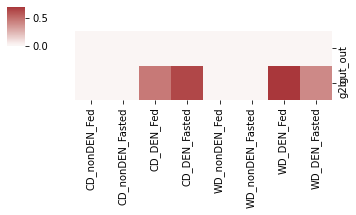

In [162]:
out = pd.DataFrame(index=['gut_out','g2b'],columns=experiments)
for item in gut_out:
    out.at['gut_out',item] = gut_out[item]
for item in g2b:
    out.at['g2b',item] = g2b[item]
out = out.fillna(0)
p = sns.clustermap(out,row_cluster=False,col_cluster=False,cmap='vlag',center=0,figsize=(5,3))
p.savefig('output/figures/'+EXP+'/propanoate_heatmap.svg')

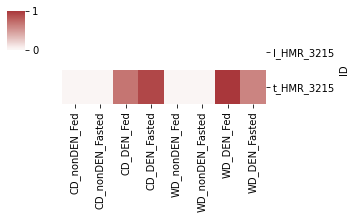

In [163]:
df = tissue_df.drop(columns=['EQUATION','SUBSYSTEM','LB','UB'])
#df = df[df.index.isin(['l_HMR_4097','t_HMR_4097'])]
df = df[df.index.isin(['l_HMR_3215','t_HMR_3215'])]

df = df.div(df.abs().max(axis=1),axis=0)
p = sns.clustermap(df,row_cluster=False,col_cluster=False,cmap='vlag',center=0,figsize=(5,3))
p.savefig('output/figures/'+EXP+'/propanoate_tissues_heatmap.svg')

In [623]:
EXPERIMENTS = ['SIM2','SIM2_CARB','SIM2_LIPID','SIM2_CARBLIPID']
experiments = ['WD_DEN_Fed','WD_DEN_Fasted']
EXPS = {}
for EXP in EXPERIMENTS:
    print(EXP)
    dfs = pd.read_excel('output/FBA/'+EXP+'.xlsx',sheet_name=experiments,index_col=0)
    for exp in experiments:
        dfs[exp] = fixSubsystems(dfs[exp])
        dfs[exp] = dfs[exp].rename(index={'community_biomass' : 'EX_community_biomass'})
    count = 0
    for exp in experiments:
        if count == 0:
            tissue_df = dfs[exp].rename(columns={'FLUX':exp})
        else:
            df = pd.DataFrame(dfs[exp]['FLUX']).rename(columns={'FLUX':exp})
            tissue_df = tissue_df.join(df,how='inner')
        count += 1
    EXPS[EXP] = tissue_df

SIM2
SIM2_CARB
SIM2_LIPID
SIM2_CARBLIPID


In [613]:
query_rxn = 'EX_M2B_C00033'

In [632]:
norm = {}
for exp in experiments:
    norm[exp] = EXPS['SIM2'].at[query_rxn,exp]
out = pd.DataFrame()
for EXP in EXPERIMENTS:
    df = EXPS[EXP]
    for exp in experiments:
        out.at[EXP,exp] = df.at[query_rxn,exp] / norm[exp]

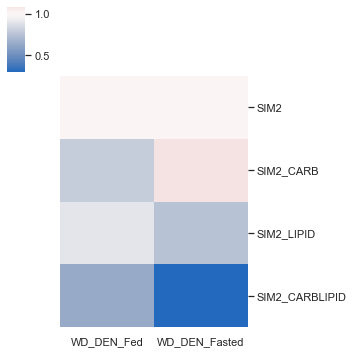

In [638]:
p = sns.clustermap(out,row_cluster=False,col_cluster=False,cmap='vlag',center=1,figsize=(5,5))
p.savefig('output/figures/'+EXP+'/acetate_sydicos.svg')

# Gluconeogenesis - SIM3

In [1439]:
out = plotSingleReaction('l_G6PPer',experiments,dfs)
#out = plotSingleReaction('t_MMRN_Biomass',experiments,dfs)
out['fc'] = out['Flux'].div(out.loc[out_comb['Model'] == 'WD_nonDEN_Fed', 'Flux'][0])
#out['logfc'] = np.log2(out['fc'])
fig = px.bar(out,x='Model',y='Flux',color='Reaction',barmode='group')
fig.update_layout(template='none',autosize=False,height=400,width=400)
fig = setPlotFont(fig)
fig.show()

In [1424]:
out

,Model,Reaction,Equation,Flux,fc,logfc
0,WD_nonDEN_Fed,l_G6PPer,glucose-6-phosphate[l_r] + H2O[l_r] => glucose...,2.656489,1.000000,0.000000
1,WD_nonDEN_Fasted,l_G6PPer,glucose-6-phosphate[l_r] + H2O[l_r] => glucose...,1.963348,0.739076,-0.436205
2,WD_DEN_Fed,l_G6PPer,glucose-6-phosphate[l_r] + H2O[l_r] => glucose...,3.376060,1.270873,0.345820
3,WD_DEN_Fasted,l_G6PPer,glucose-6-phosphate[l_r] + H2O[l_r] => glucose...,3.708067,1.395852,0.481146


In [1417]:
out_comb['Flux'].div(out_comb.loc[out_comb['Model'] == 'WD_nonDEN_Fed', 'Flux'][0])

0    1.000000
1    0.739076
2    1.270873
3    1.395852
Name: Flux, dtype: float64

In [1461]:
Msens = mat73.loadmat('output/sensitivity/Msens.mat')
Msens = Msens['Msens']
Msens

{'Msens': [array([[-0.        , -0.        ],
         [-0.        ,  0.        ],
         [-0.        , -0.        ],
         ...,
         [ 5.17873115,  5.18728587],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]]),
  array([[-0.        , -0.        ],
         [ 0.02248542, -0.        ],
         [-0.        , -0.        ],
         ...,
         [ 5.56885299,  5.56885299],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]]),
  array([[ 4.97376879e-02,  5.25094929e-02],
         [ 6.41768380e-03,  6.77533147e-03],
         [ 1.92535622e-02,  2.03265336e-02],
         ...,
         [ 7.24690474e+00,  7.23878591e+00],
         [-5.00000000e-01, -5.00000000e-01],
         [-5.00000000e-01, -5.00000000e-01]]),
  array([[ 5.04401120e-02,  5.11969778e-02],
         [ 6.50831801e-03,  6.60597685e-03],
         [ 1.95254720e-02,  1.98184563e-02],
         ...,
         [ 7.78438809e+00,  7.78237479e+00],
         [-5.00000000e-01, -5.00000

In [1472]:
counter = 0
m_dfs = {}
for model in Msens['model']:
    arr = Msens['Msens'][counter]
    rxns = [x[0] for x in Msens['rxns'][counter]]
    m_dfs[model] = pd.DataFrame(index=rxns,data=arr)
    counter += 1

In [1508]:
m_dfs['WD_nonDEN_Fasted'].loc['l_EXC_BOTH_C00031[s]']

0    10.193789
1    10.239415
Name: l_EXC_BOTH_C00031[s], dtype: float64

In [1457]:
m_dfs['WD_nonDEN_Fed']['EQUATION']

ID
EX_His_d2b                                     histidine[d] => histidine[b]
EX_Ile_d2b                                   isoleucine[d] => isoleucine[b]
EX_Leu_d2b                                         leucine[d] => leucine[b]
EX_Linoleate_d2b                               linoleate[d] => linoleate[b]
EX_Linolenate_d2b                            linolenate[d] => linolenate[b]
                                                ...                        
l2t_EXC_BOTH_C00366[s]                            Urate[t_s] <=> Urate[l_s]
l2t_EXC_BOTH_C00086[s]                              urea[t_s] <=> urea[l_s]
l2t_EXC_BOTH_C00299[s]                        uridine[t_s] <=> uridine[l_s]
EXC_BOTH_m46[b]                       CDP-diacylglycerol-LD-PI pool[b] <=> 
t_EXC_BOTH_m46[c]         CDP-diacylglycerol-LD-PI pool[t_c] <=> CDP-dia...
Name: EQUATION, Length: 47452, dtype: object

# Gluconeogenesis - SIM3 - sensitivity

In [18]:
mat_contents = mat73.loadmat('output/sensitivity/Msens.mat')

In [87]:
Msens = mat_contents['Msens']
sens = Msens['Msens']
rxns = []
for i in Msens['rxns']:
    l = [x[0] for x in i]
    rxns.append(l)
models = Msens['model']
counter = 0
dfs = {}
for model in models:
    df = pd.DataFrame(index=rxns[counter],data=sens[counter])
    dfs[model] = df
    counter += 1

In [94]:
x = 'l_G6PPer'
y = 'l2t_EXC_BOTH_C00031[s]'
d = []
for model in dfs:
    dat = zip(dfs[model].loc[x],dfs[model].loc[y])
    for i in dat:
        d.append({'Model' : model,
                  x : i[0],
                  y : i[1]})
toPlot = pd.DataFrame(d)

In [95]:
fig = px.line(toPlot,x=x,y=y,template='none',facet_row='Model')
fig.show()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
EX_His_d2b,-0.000000,0.096774,0.096774,0.096774,0.096774,0.096774,0.096774,0.096774,0.096774,0.096774,...,0.095184,0.092526,0.089843,0.087081,0.084243,0.081341,0.078397,0.075351,0.072229,0.003945
EX_Ile_d2b,-0.000000,0.013007,-0.000000,0.013007,0.013007,0.013007,0.013007,0.013007,0.013007,0.013002,...,0.012282,0.011939,0.011592,0.011236,0.010870,0.010495,0.010116,0.009723,0.009320,-0.000000
EX_Leu_d2b,0.039023,0.039023,0.039023,0.039023,0.039023,0.039023,0.039023,0.039023,0.039023,0.039008,...,0.036846,0.035817,0.034778,0.033709,0.032611,0.031487,0.030347,0.029169,0.027960,0.001527
EX_Linoleate_d2b,0.114460,0.114460,0.114460,0.092159,0.114460,0.114460,0.092159,0.114460,0.114460,0.114460,...,0.114460,0.114460,0.114460,0.114460,0.114460,0.114460,0.114460,0.114460,0.114460,0.114460
EX_Linolenate_d2b,0.010775,0.010775,0.010775,0.010775,0.010775,0.010775,0.010775,0.010775,0.010775,0.010775,...,0.010775,0.010775,0.010775,0.010775,0.010775,0.010775,0.010775,0.010775,0.010775,0.010775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l2t_EXC_BOTH_C00366[s],996.512927,996.512927,996.512927,996.512927,996.512927,996.512927,996.512927,996.512927,996.512927,996.512927,...,996.512927,996.512927,996.512927,996.512927,996.512927,996.512927,996.512927,996.512927,996.512927,996.512927
l2t_EXC_BOTH_C00086[s],-996.512927,-996.512927,-996.512927,-996.512927,-996.512927,-996.512927,-996.512927,-996.512927,-996.512927,-996.512927,...,-996.512927,-996.512927,-996.512927,-996.512927,-996.512927,-996.512927,-996.512927,-996.512927,-996.512927,-996.187268
l2t_EXC_BOTH_C00299[s],1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
EXC_BOTH_m46[b],-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,...,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000


In [190]:
fba = pd.read_excel('output/FBA/SIM_Obesity.xlsx',index_col=0)
models = ['CD_NC_12','CD_NC_25','CD_NC_50','CD_WD_12','CD_WD_25','CD_WD_50',
          'WD_NC_12','WD_NC_25','WD_NC_50','WD_WD_12','WD_WD_25','WD_WD_50',]
for model in models:
    fba.at['EXC_OUT_Biomass',model] = -fba.at['EXC_OUT_Biomass',model]
    fba.at['EXC_OUT_C00011[s]',model] = -fba.at['EXC_OUT_C00011[s]',model]

In [197]:
carbon_matrix['LDL[l_s]'] = 36720
carbon_matrix['cholesterol-ester pool[l_c]'] = 0

In [198]:
df = fba[fba['SUBSYSTEM'] == 'Exchange reactions']
influx = []
efflux = []
for model in models:
    for index,row in df.iterrows():
        metabolite = row['EQUATION'].replace('<=>','').strip()
        metabolite = metabolite.replace('=>','').strip()
        metabolite = metabolite.replace('[s]','[l_s]').strip()
        metabolite = metabolite.replace('[c]','[l_c]')
        metabolite_full = metabolite.replace('[l]','[l_c]')
        met_parts = metabolite_full.split('[')
        metabolite = str('['.join(met_parts[0:-1]))
        if metabolite in metabolite_group_map:
            met_group = metabolite_group_map[metabolite]
        else:
            met_group = 'Other'
        if row[model] > 0:
            influx.append({'Model' : model,
                           'Flux' : row[model],
                           'Metabolite' : metabolite,
                           'Metabolite_full' : metabolite_full,
                           'Cmoles' : row[model] * carbon_matrix[metabolite_full],
                           'Metabolite_group' : met_group})
        if row[model] < 0:
            efflux.append({'Model' : model,
                           'Flux' : abs(row[model]),
                           'Metabolite' : metabolite,
                           'Metabolite_full' : metabolite_full,
                           'Cmoles' : abs(row[model]) * carbon_matrix[metabolite_full],
                           'Metabolite_group' : met_group})
toPlot_influx = pd.DataFrame(influx) 
toPlot_efflux = pd.DataFrame(efflux)

In [199]:
Cmoles_IN = toPlot_influx.groupby(['Model']).sum()['Cmoles']
Cmoles_OUT = toPlot_efflux.groupby(['Model']).sum()['Cmoles']
biomass = dict(Cmoles_IN - Cmoles_OUT)
for model in biomass:
    i = toPlot_efflux[(toPlot_efflux.Model == model) & (toPlot_efflux.Metabolite == 'biomass')].index[0]
    toPlot_efflux.at[i,'Cmoles'] = biomass[model]

In [200]:
cols = plotly.colors.qualitative.Pastel[0:7]
toPlot_influx_final = toPlot_influx[~toPlot_influx['Metabolite_group'].isin(['Other'])]
fig = px.bar(toPlot_influx_final,x='Model',y='Cmoles',color='Metabolite_group',
             color_discrete_sequence=[cols[3],cols[2],cols[1]],
             category_orders={"Metabolite_group": ['Carbohydrate','Lipid','Amino Acid']})
fig.update_layout(template='none',autosize=False,width=400,height=300)
fig.update_yaxes(title='', visible=True, showticklabels=True)
#fig.update_xaxes(title='', visible=False, showticklabels=True)
#fig.update_yaxes(range=[0, toPlot_input_diet[toPlot_input_diet['Model'] == 'WD_DEN_Fed']['Flux'].sum()])
fig = setPlotFont(fig)
#fig.write_image('output/figures/SIM1/input_diet.svg')
fig.show()

In [206]:
toPlot_efflux = toPlot_efflux.replace({'Metabolite_group':{'Lipids' : 'Other','Amino acids' : 'Other'}})
fig = px.bar(toPlot_efflux,x='Model',y='Cmoles',color='Metabolite',
             #color_discrete_sequence=['black','darkgrey','grey'],
             category_orders={"Metabolite_group": ['biomass','CO2','Other']})
fig.update_layout(template='none',autosize=False,width=400,height=300)
fig.update_yaxes(title='', visible=True, showticklabels=True)
fig.update_xaxes(title='', visible=False, showticklabels=True)
fig.update_xaxes(categoryorder='array', categoryarray=models)
fig = setPlotFont(fig)
#fig.write_image('output/figures/SIM1/output_blood.svg')
fig.show()

In [205]:
toPlot_efflux = toPlot_efflux.replace({'Metabolite_group':{'Lipids' : 'Other','Amino acids' : 'Other'}})
fig = px.bar(toPlot_efflux,x='Model',y='Flux',color='Metabolite_group',
             color_discrete_sequence=['black','darkgrey','grey'],
             category_orders={"Metabolite_group": ['biomass','CO2','Other']})
fig.update_layout(template='none',autosize=False,width=400,height=300)
fig.update_yaxes(title='', visible=True, showticklabels=True)
fig.update_xaxes(title='', visible=False, showticklabels=True)
fig.update_xaxes(categoryorder='array', categoryarray=models)
fig = setPlotFont(fig)
#fig.write_image('output/figures/SIM1/output_blood.svg')
fig.show()

In [17]:
import collections
fin = open('acro.txt','r')
d = {}
for line in fin:
    line = line.replace("\\acro","")
    parts = line.split('}{')
    d[parts[0].replace('{','').strip()] = parts[1].replace('}','').strip()
fin.close()
od = dict(collections.OrderedDict(sorted(d.items())))

for item in od:
    print('  ''\\acro{'+item+'}{'+od[item]+'}')

  \acro{ACC}{acetyl-coenzyme A carboxylase}
  \acro{AGORA}{Assembly of Gut micrOorganisms through Reconstruction and Analysis}
  \acro{AMP}{adenosine monophosphate}
  \acro{ATGL}{adipose triglyceride lipase}
  \acro{BA}{bile acid}
  \acro{BiGG}{biochemical, genetic and genomic}
  \acro{CBM}{constraint-based modelling}
  \acro{CD}{control diet}
  \acro{COBRA}{constraint-based reconstruction and analysis}
  \acro{CPT}{carnitine palmitoyltransferase}
  \acro{ChREBP}{carbohydrate-responsive element-binding protein}
  \acro{DEN}{diethylnitrosamine}
  \acro{DGE}{differential gene expression}
  \acro{DNL}{\emph{De novo lipogenesis}
  \acro{EHMN}{Edinburgh Human Metabolic Network}
  \acro{ER}{endoplasmic reticulum}
  \acro{FA}{fatty acid}
  \acro{FAS}{fatty acid synthase}
  \acro{FBA}{flux balance analysis}
  \acro{FPKM}{fragments per kilobase million}
  \acro{FXR}{farnesoid X receptor}
  \acro{G3P}{glycerol-3-phosphate}
  \acro{GK}{glucokinase}
  \acro{GLS}{Glutaminase}
  \acro{GLUT}{glucose 